# Level 1
This notebooks explains the process of obtaining the prior mean and variance estimates for Level 1.

## Imports

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import norm
import os

from bmpe.utils import (
    binomial_loglik,
    fit_model, 
    cum_gauss,
    logistic
)

## Get data

In [60]:
data_dir = "../data"
experiment_name = "experiment_1"
source_of_data = "website_output"
type_of_data_input = "processed"
type_of_var = "mean"
test_n = 2
test = f"test{test_n}"

folder_mean = os.path.join(
    data_dir,
    experiment_name,
    source_of_data,
    type_of_data_input,
    type_of_var,
    test
)

input_file_name_mean = f"{type_of_var}_outputs_experiment_1.csv"
input_file_mean = os.path.join(folder_mean, input_file_name_mean)

type_of_var = "variance"
test_n = 8
test = f"test{test_n}"
folder_variance = os.path.join(
    data_dir,
    experiment_name,
    source_of_data,
    type_of_data_input,
    type_of_var,
    test
)
input_file_name_variance =  f"{type_of_var}_outputs_experiment_1.csv"
input_file_variance = os.path.join(folder_variance, input_file_name_variance)

In [61]:
df_mean = pd.read_csv(input_file_mean)
df_variance = pd.read_csv(input_file_variance)

## 1. Mean Estimate

### Experiment
We decided to vary the difference between S1 and S2 in small increments and observe the pattern of responses.

We had two values: S1 and S2.
We set S2 ~ $ N(0,8^2) to be the reference

We chose a very large standard deviation because, if the agent indeed relies on a "prior", then we should be able to see that. [how???]

### Analysis
After some derivation, [beautifully explained in a nice comic made by Rowan](../manuscripts/level_1_mean_estimate_explanation.pdf), we arrived to the conclusion that to estimate the mean of our priors, we must find the threshold of the probit function.

This threshold will be centered at $\frac{\mu_D}{\sigma_D} = 0$

In [62]:
###

In [63]:
# df is the combined psychometric data:
# columns expected: S1_val, S1_std, P_choose1, N_trials

# Pool across S1_std: weighted by number of trials
# Group data by stimulus variable
# Compute weighted average of P_choose1
# Compute total number of trials
group_pool = (
    df_mean.groupby("S1_val")
      .apply(lambda g: pd.Series({
          "P_choose1": np.average(g["P_choose1"], weights=g["N_trials"]),
          "N_trials":  g["N_trials"].sum()
      })).reset_index()
)

x_data = group_pool["S1_val"].values.astype(float)
p_data = group_pool["P_choose1"].values.astype(float)
n_data = group_pool["N_trials"].values.astype(int)
k_data = np.round(p_data * n_data).astype(int)   # approximate counts

# sanity check: monotonic-ish
print(group_pool.head())

# initial guesses: threshold p ~ 0.5
idx50 = np.argmin(np.abs(p_data - 0.5))
mu_guess = x_data[idx50]

probit_params, probit_aic, probit_p = fit_model(
    x_data, p_data, n_data,
    model=cum_gauss,
    p0=[mu_guess, 1.0],
    bounds=([-np.inf, 1e-4], [np.inf, np.inf])
)

mu_probit, sigma_probit = probit_params
print(f"Probit:   mu={mu_probit:.4f}, sigma={sigma_probit:.4f}")



   S1_val  P_choose1  N_trials
0    -4.0    0.02735   20000.0
1    -3.9    0.03085   20000.0
2    -3.8    0.03295   20000.0
3    -3.7    0.03810   20000.0
4    -3.6    0.04340   20000.0
Probit:   mu=-0.8161, sigma=1.5870


/var/folders/78/8gqygqxn7snfdc3z73g03hg00000gn/T/ipykernel_8971/1172003164.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


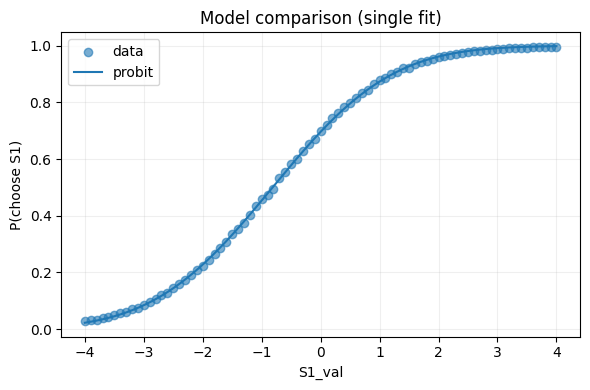

In [64]:
xx = np.linspace(x_data.min(), x_data.max(), 400)
plt.figure(figsize=(6,4))
plt.scatter(x_data, p_data, label="data", alpha=0.6)
plt.plot(xx, cum_gauss(xx, *probit_params), label="probit")
#plt.plot(xx, logistic(xx, *logit_params), label="logistic")
plt.xlabel("S1_val")
plt.ylabel("P(choose S1)")
plt.title("Model comparison (single fit)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [65]:
n_boot = 1000  

mu_boot_probit = []
mu_boot_logit  = []

rng = np.random.default_rng(42)

for b in range(n_boot):
    # resample counts per S1_val
    k_boot = rng.binomial(n=n_data, p=p_data)
    p_boot = k_boot / n_data

    # skip weird cases
    if (p_boot <= 0).all() or (p_boot >= 1).all():
        continue

    try:
        params_p, _, _ = fit_model(
            x_data, p_boot, n_data,
            model=cum_gauss,
            p0=[mu_probit, sigma_probit],
            bounds=([-np.inf, 1e-4], [np.inf, np.inf])
        )
        mu_b, sigma_b = params_p
        mu_boot_probit.append(mu_b)
    except Exception:
        continue

    try:
        params_l, _, _ = fit_model(
            x_data, p_boot, n_data,
            model=logistic,
            p0=[mu_logit, s_logit],
            bounds=([-np.inf, 1e-4], [np.inf, np.inf])
        )
        mu_b, s_b = params_l
        mu_boot_logit.append(mu_b)
    except Exception:
        continue

    except Exception:
        continue

print(f"\nBootstraps kept: probit={len(mu_boot_probit)}, "
      f"logit={len(mu_boot_logit)}")


Bootstraps kept: probit=1000, logit=0


In [66]:
def summarize(name, samples):
    samples = np.asarray(samples)
    m  = samples.mean()
    sd = samples.std()
    lo, hi = np.percentile(samples, [2.5, 97.5])
    print(f"{name}: mean={m:.4f}, sd={sd:.4f}, 95% CI [{lo:.4f}, {hi:.4f}]")

print("\n=== BOOTSTRAP PRIOR MEAN ESTIMATES ===")
summarize("Probit  μ50",  mu_boot_probit)
#summarize("Logistic μ50", mu_boot_logit)



=== BOOTSTRAP PRIOR MEAN ESTIMATES ===
Probit  μ50: mean=-0.8160, sd=0.0023, 95% CI [-0.8204, -0.8117]


## 2. Variance Estimate

In [45]:
file = "../data/experiment_1/website_output/processed/variance/test9/variance_outputs_experiment_1.csv"
stims = "S1_val"
choice = "P_choose1"

In [46]:
df = pd.read_csv(file)
required_cols = {"S1_std", "S2_std", "S1_val", "S2_val", "P_choose1", "N_trials"}

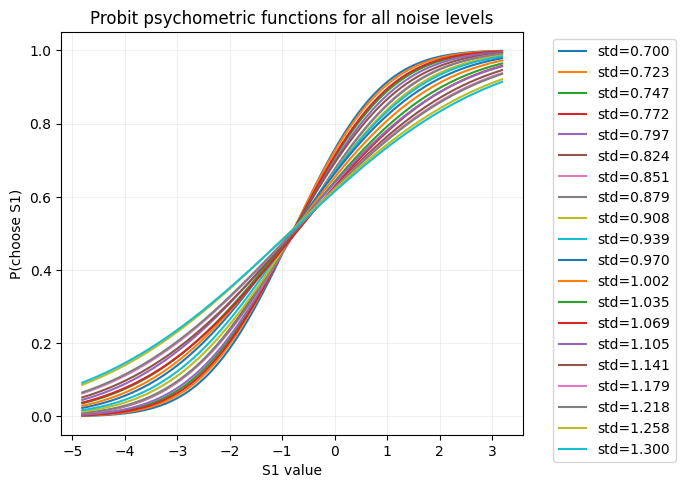

In [47]:
fit_results = []

global_xmin = df["S1_val"].min()
global_xmax = df["S1_val"].max()

unique_stds = sorted(df["S1_std"].unique())

plt.figure(figsize=(7, 5))

for std in unique_stds:
    block = df[df["S1_std"] == std].sort_values("S1_val")
    x = block["S1_val"].values.astype(float)
    p = block["P_choose1"].values.astype(float)
    n = block["N_trials"].values.astype(float)

    if (p <= 0).all() or (p >= 1).all():
        print(f"Skipping S1_std={std}: saturated responses.")
        continue

    idx50 = np.argmin(np.abs(p - 0.5))
    mu_init = x[idx50]
    sigma_init = 1.0  
    
    weights = np.sqrt(n)  

    try:
        (mu_hat, sigma_hat), pcov = curve_fit(
            cum_gauss,
            x,
            p,
            p0=[mu_init, sigma_init],
            bounds=([-np.inf, 1e-4], [np.inf, np.inf]),
            sigma=1.0 / weights,   
            absolute_sigma=False,
            maxfev=20000,
        )
    except RuntimeError:
        print(f"[WARN] Probit fit failed for S1_std={std}")
        continue

    # Store results
    fit_results.append({
        "S1_std": std,
        "mu_hat": mu_hat,           
        "sigma_hat": sigma_hat,     
    })

    xx = np.linspace(global_xmin, global_xmax, 400)
    yy = cum_gauss(xx, mu_hat, sigma_hat)
    plt.plot(xx, yy, label=f"std={std:.3f}")

plt.xlabel("S1 value")
plt.ylabel("P(choose S1)")
plt.title("Probit psychometric functions for all noise levels")
plt.ylim([-0.05, 1.05])
plt.grid(alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

slopes_df = pd.DataFrame(fit_results)
if slopes_df.empty:
    raise RuntimeError("No valid probit fits; cannot estimate prior variance.")

In [48]:
slopes_df = slopes_df.dropna(subset=["sigma_hat", "S1_std"]).copy()
slopes_df = slopes_df[(slopes_df["sigma_hat"] > 0) & (slopes_df["S1_std"] > 0)]

# Keep only mid-range sigmas (tune these)
SIGMA_MIN = 0.4   # too steep below this
SIGMA_MAX = 3.3   # too flat above this

good = (slopes_df["sigma_hat"] >= SIGMA_MIN) & (slopes_df["sigma_hat"] <= SIGMA_MAX)
slopes_clean = slopes_df[good].copy()

print(f"Using {len(slopes_clean)} blocks out of {len(slopes_df)} after sigma filter.")

Using 20 blocks out of 20 after sigma filter.


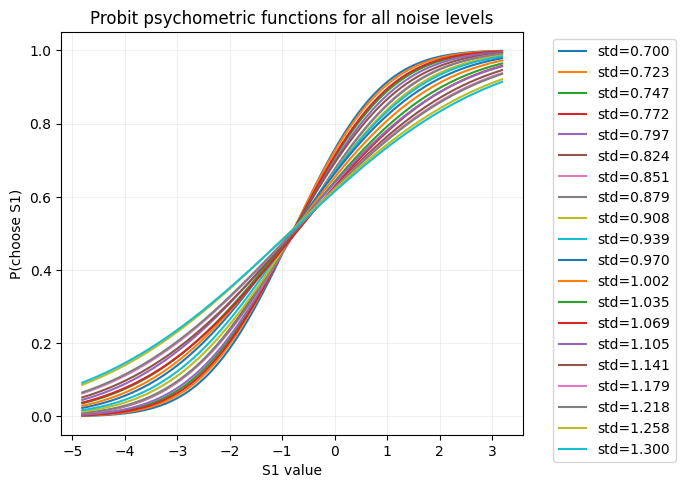

Using 20 blocks out of 20 after sigma filter.
C_hat     = 0.4621718012961106
tau0_hat  = 0.7551235459656029
sigma0²   = 1.3242866089167766

===== PRIOR VARIANCE ESTIMATE (THEORY FIT) =====
C_hat:        0.4622 ± 0.3047
tau_0:        0.7551 ± 0.7284 (95% CI [-0.6726, 2.1828])
sigma_0²:     1.3243 ± 1.2775 (95% CI [-1.1795, 3.8281])
sigma0: mean=1.1508, 95% CI [nan, 1.9566]


/var/folders/s4/z3qm0kcs63v02zyrflt62gq80000gn/T/ipykernel_36979/3973502495.py:149: RuntimeWarning: invalid value encountered in sqrt
  print(f"sigma0: mean={np.sqrt(sigma0_sq_hat):.4f}, 95% CI [{np.sqrt(sig0_lo):.4f}, {np.sqrt(sig0_hi):.4f}]")


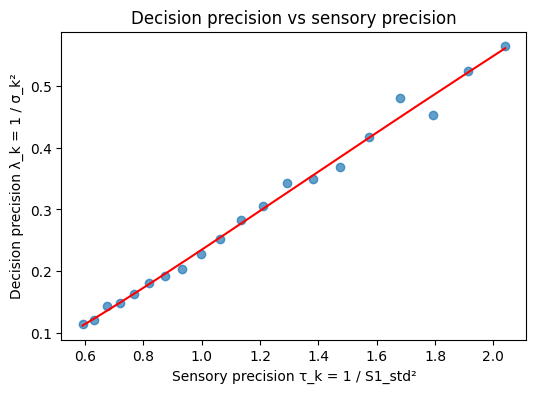


===== BOOTSTRAP (BLOCK-LEVEL) =====
tau_0:  mean=10.0469, 95% CI [0.3913, 71.3756]
sigma0²: mean=1.2245, 95% CI [0.0140, 2.5556]
sigma0: mean=1.1066, 95% CI [0.1184, 1.5986]


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

# ==============================================
# 1. PSYCHOMETRIC FITS (CUMULATIVE GAUSS)
# ==============================================


fit_results = []

global_xmin = df["S1_val"].min()
global_xmax = df["S1_val"].max()

unique_stds = sorted(df["S1_std"].unique())

plt.figure(figsize=(7, 5))

for std in unique_stds:
    block = df[df["S1_std"] == std].sort_values("S1_val")
    x = block["S1_val"].values.astype(float)
    p = block["P_choose1"].values.astype(float)
    n = block["N_trials"].values.astype(float)

    # Skip degenerate curves (all 0 or all 1)
    if (p <= 0).all() or (p >= 1).all():
        print(f"[INFO] Skipping S1_std={std}: saturated responses.")
        continue

    # Initial guess: threshold near 0.5, width ~ 1
    idx50 = np.argmin(np.abs(p - 0.5))
    mu_init = x[idx50]
    sigma_init = 1.0

    # Weights: more trials -> smaller noise
    weights = np.sqrt(n)

    try:
        (mu_hat, sigma_hat), pcov = curve_fit(
            cum_gauss,
            x,
            p,
            p0=[mu_init, sigma_init],
            bounds=([-np.inf, 1e-4], [np.inf, np.inf]),
            sigma=1.0 / weights,   # inverse of weights as error
            absolute_sigma=False,
            maxfev=20000,
        )
    except RuntimeError:
        print(f"[WARN] Probit fit failed for S1_std={std}")
        continue

    fit_results.append({
        "S1_std": std,
        "mu_hat": mu_hat,           # PSE for this noise block
        "sigma_hat": sigma_hat,     # psychometric width
    })

    xx = np.linspace(global_xmin, global_xmax, 400)
    yy = cum_gauss(xx, mu_hat, sigma_hat)
    plt.plot(xx, yy, label=f"std={std:.3f}")

plt.xlabel("S1 value")
plt.ylabel("P(choose S1)")
plt.title("Probit psychometric functions for all noise levels")
plt.ylim([-0.05, 1.05])
plt.grid(alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

slopes_df = pd.DataFrame(fit_results)
if slopes_df.empty:
    raise RuntimeError("No valid probit fits; cannot estimate prior variance.")

# ==============================================
# 2. CLEAN SLOPE DATA & COMPUTE λ_k, τ_k
# ==============================================

# Drop any pathological blocks
slopes_df = slopes_df.dropna(subset=["sigma_hat", "S1_std"]).copy()
slopes_df = slopes_df[(slopes_df["sigma_hat"] > 0) & (slopes_df["S1_std"] > 0)]

# You can optionally filter out completely crazy sigma_hat values.
# Here: keep everything, or use loose bounds:
SIGMA_MIN = 0.1
SIGMA_MAX = 10.0
good = (slopes_df["sigma_hat"] >= SIGMA_MIN) & (slopes_df["sigma_hat"] <= SIGMA_MAX)
slopes_clean = slopes_df[good].copy()

print(f"Using {len(slopes_clean)} blocks out of {len(slopes_df)} after sigma filter.")

# Decision precision and sensory precision per block
slopes_clean["lambda_hat"] = 1.0 / (slopes_clean["sigma_hat"]**2)
slopes_clean["tau_k"]      = 1.0 / (slopes_clean["S1_std"]**2)

x = slopes_clean["tau_k"].values
y = slopes_clean["lambda_hat"].values

def theory_lambda(tau_k, C, tau0, int_n):
    # Nonlinear theory-consistent mapping:
    # λ_k = C * τ_k² / (τ0 + τ_k)
    sigma_k2 = 1/tau_k
    tau_sens = 1/(sigma_k2+int_n**2)
    return C * ((tau_sens)**2) / (tau0 + tau_sens)


C0 = (y[-1] - y[0]) / (x[-1] - x[0]) if len(x) > 1 else 0.1
tau00 = 1.0
int_n0 = 0.5
p0 = [C0, tau00,int_n0]

(C_hat, tau0_hat, int_n_hat), pcov = curve_fit(
    theory_lambda,
    x, y,
    p0=p0,
    bounds=([0.0, 0.0, 0.0], [np.inf,np.inf, np.inf])  # enforce C>=0, tau0>=0
)

sigma0_sq_hat = 1.0 / tau0_hat

print("C_hat     =", C_hat)
print("tau0_hat  =", tau0_hat)
print("sigma0²   =", sigma0_sq_hat)

# --- CIs from covariance (approx normal) ---
C_var, tau0_var = pcov[0, 0], pcov[1, 1]
C_se,  tau0_se  = np.sqrt(C_var), np.sqrt(tau0_var)

tau0_lo = tau0_hat - 1.96 * tau0_se
tau0_hi = tau0_hat + 1.96 * tau0_se

# propagate to sigma0² = 1 / tau0 via delta method
d_sig0sq_dtau0 = -1.0 / (tau0_hat**2)
sig0_var = (d_sig0sq_dtau0**2) * tau0_var
sig0_se  = np.sqrt(sig0_var)

sig0_lo = sigma0_sq_hat - 1.96 * sig0_se
sig0_hi = sigma0_sq_hat + 1.96 * sig0_se

print("\n===== PRIOR VARIANCE ESTIMATE (THEORY FIT) =====")
print(f"C_hat:        {C_hat:.4f} ± {C_se:.4f}")
print(f"tau_0:        {tau0_hat:.4f} ± {tau0_se:.4f} "
      f"(95% CI [{tau0_lo:.4f}, {tau0_hi:.4f}])")
print(f"sigma_0²:     {sigma0_sq_hat:.4f} ± {sig0_se:.4f} "
      f"(95% CI [{sig0_lo:.4f}, {sig0_hi:.4f}])")
print(f"sigma0: mean={np.sqrt(sigma0_sq_hat):.4f}, 95% CI [{np.sqrt(sig0_lo):.4f}, {np.sqrt(sig0_hi):.4f}]")
print("================================================")

# --- Plot λ_k vs τ_k + theory line ---
tau_line = np.linspace(x.min(), x.max(), 200)
lambda_line = theory_lambda(tau_line, C_hat, tau0_hat, int_n_hat)

plt.figure(figsize=(6,4))
plt.scatter(x, y, label="Observed λ_k", alpha=0.7)
plt.plot(tau_line, lambda_line, 'r', label="Fit: λ_k = C(τ0 + τ_k)")
plt.xlabel("Sensory precision τ_k = 1 / S1_std²")
plt.ylabel("Decision precision λ_k = 1 / σ_k²")
plt.title("Decision precision vs sensory precision")
plt.show()

# ==============================================
# 4. BOOTSTRAP OVER BLOCKS
# ==============================================

N_BOOT = 500
tau0_boot = []
sig0_boot = []

tau_k_all = slopes_clean["tau_k"].values
lambda_all = slopes_clean["lambda_hat"].values

for _ in range(N_BOOT):
    idx = np.random.choice(len(tau_k_all), size=len(tau_k_all), replace=True)
    xb = tau_k_all[idx]
    yb = lambda_all[idx]

    try:
        (C_b, tau0_b, int_n_b), _ = curve_fit(
            theory_lambda,
            xb, yb,
            p0=[C_hat, tau0_hat, int_n_hat],
            bounds=([0.0, 0.0, 0.0], [np.inf,np.inf, np.inf]),
            maxfev=20000
        )
    except RuntimeError:
        continue

    tau0_boot.append(tau0_b)
    sig0_boot.append(1.0 / tau0_b)

tau0_boot = np.array(tau0_boot)
sig0_boot = np.array(sig0_boot)

tau0_mean = np.mean(tau0_boot)
sig0_mean = np.mean(sig0_boot)

tau0_ci = np.percentile(tau0_boot, [2.5, 97.5])
sig0_ci = np.percentile(sig0_boot, [2.5, 97.5])

print("\n===== BOOTSTRAP (BLOCK-LEVEL) =====")
print(f"tau_0:  mean={tau0_mean:.4f}, 95% CI [{tau0_ci[0]:.4f}, {tau0_ci[1]:.4f}]")
print(f"sigma0²: mean={sig0_mean:.4f}, 95% CI [{sig0_ci[0]:.4f}, {sig0_ci[1]:.4f}]")
print(f"sigma0: mean={np.sqrt(sig0_mean):.4f}, 95% CI [{np.sqrt(sig0_ci[0]):.4f}, {np.sqrt(sig0_ci[1]):.4f}]")
print("===================================")

In [50]:
import numpy as np

N_BOOT = 1000
tau0_boot = []
sig0_boot = []

tau_k_all = slopes_clean["tau_k"].values
lambda_all = slopes_clean["lambda_hat"].values

for _ in range(N_BOOT):
    # resample indices of blocks with replacement
    idx = np.random.choice(len(tau_k_all), size=len(tau_k_all), replace=True)
    xb = tau_k_all[idx]
    yb = lambda_all[idx]

    try:
        (C_b, tau0_b), _ = curve_fit(
            theory_lambda,
            xb, yb,
            p0=[C_hat, tau0_hat],
            bounds=([0.0, 0.0], [np.inf, np.inf]),
            maxfev=20000
        )
    except RuntimeError:
        # skip failed fits
        continue

    tau0_boot.append(tau0_b)
    sig0_boot.append(1.0 / tau0_b)

tau0_boot = np.array(tau0_boot)
sig0_boot = np.array(sig0_boot)

tau0_mean = np.mean(tau0_boot)
sig0_mean = np.mean(sig0_boot)

tau0_ci = np.percentile(tau0_boot, [2.5, 97.5])
sig0_ci = np.percentile(sig0_boot, [2.5, 97.5])

print("\n===== BOOTSTRAP (BLOCK-LEVEL) =====")
print(f"tau_0:  mean={tau0_mean:.4f}, 95% CI [{tau0_ci[0]:.4f}, {tau0_ci[1]:.4f}]")
print(f"sigma0²: mean={sig0_mean:.4f}, 95% CI [{sig0_ci[0]:.4f}, {sig0_ci[1]:.4f}]")
print("===================================")

TypeError: theory_lambda() missing 1 required positional argument: 'int_n'

In [73]:
slopes_df["tau_k"] = 1.0 / (slopes_df["S1_std"] ** 2)

print("\n===== PSYCHOMETRIC FIT RESULTS (VARIANCE EXP) =====")
print(slopes_df.sort_values("S1_std"))


===== PSYCHOMETRIC FIT RESULTS (VARIANCE EXP) =====
      S1_std    mu_hat  sigma_hat     tau_k
0   0.700000 -0.841339   1.121705  2.040816
1   0.881945 -0.776850   1.349082  1.285634
2   1.111181 -0.773766   1.883310  0.809898
3   1.400000 -0.767306   2.475752  0.510204
4   1.500000 -0.847486   2.914387  0.444444
5   1.563556 -0.719836   2.967767  0.409047
6   1.629805 -0.723973   3.233529  0.376468
7   1.698862 -0.705388   3.335095  0.346485
8   1.770844 -0.799933   3.904654  0.318889
9   1.845876 -0.719076   3.778404  0.293491
10  1.924087 -0.824134   4.416343  0.270116
11  2.005612 -0.559289   4.327542  0.248603
12  2.090592 -0.793767   4.708885  0.228803
13  2.179172 -0.674164   5.293283  0.210580
14  2.271505 -0.912539   6.108493  0.193808
15  2.367751 -0.981167   5.512357  0.178373
16  2.468074 -0.672787   6.459437  0.164166
17  2.572649 -1.062517   7.282132  0.151091
18  2.681654 -0.811173   7.511762  0.139058
19  2.795278 -0.762268   8.321810  0.127982
20  2.913716 -0.717966 

In [74]:
slopes_df["lambda_hat"] = 1.0 / (slopes_df["sigma_hat"] ** 2)

# keep only sane values
mask = np.isfinite(slopes_df["lambda_hat"]) & (slopes_df["lambda_hat"] > 0)
slopes_df = slopes_df[mask].copy()

x = slopes_df["tau_k"].values        # sensory precision
y = slopes_df["lambda_hat"].values   # decision precision

In [75]:
X = np.vstack([x, np.ones_like(x)]).T  # design matrix
beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
a, b = beta  

# residuals and noise variance estimate
y_pred = a * x + b
resid = y - y_pred
dof = len(x) - 2
sigma_eps2 = np.sum(resid**2) / dof

# covariance matrix of [a, b]
XtX_inv = np.linalg.inv(X.T @ X)
cov_beta = sigma_eps2 * XtX_inv
var_a  = cov_beta[0, 0]
var_b  = cov_beta[1, 1]
cov_ab = cov_beta[0, 1]

C_est      = a
tau0_est   = b / a                 
sigma0_sq_est = 1.0 / tau0_est     

d_tau0_da = -b / (a**2)
d_tau0_db =  1.0 / a

var_tau0 = (
    d_tau0_da**2 * var_a +
    d_tau0_db**2 * var_b +
    2 * d_tau0_da * d_tau0_db * cov_ab
)
se_tau0 = np.sqrt(var_tau0)

tau0_lo = tau0_est - 1.96 * se_tau0
tau0_hi = tau0_est + 1.96 * se_tau0

# Delta method for sigma0² = 1 / tau0
d_sig0sq_dtau0 = -1.0 / (tau0_est**2)
var_sig0_sq = (d_sig0sq_dtau0**2) * var_tau0
se_sigma0_sq = np.sqrt(var_sig0_sq)

sig0_lo = sigma0_sq_est - 1.96 * se_sigma0_sq
sig0_hi = sigma0_sq_est + 1.96 * se_sigma0_sq


===== PRIOR VARIANCE ESTIMATE (SLOPE-BASED) =====
a (slope C):            0.410416
b (intercept C*tau0):   -0.038360
tau_0 (prior precision) = -0.093466 (95% CI [-0.114130, -0.072803])
sigma_0² (prior var)    = -10.699048 (95% CI [-13.064394, -8.333703])


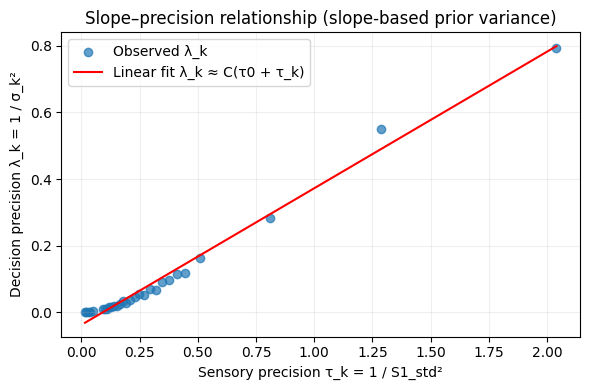

In [76]:

# ------------------------------------------
# Print results
# ------------------------------------------
print("===== PRIOR VARIANCE ESTIMATE (SLOPE-BASED) =====")
print(f"a (slope C):            {C_est:.6f}")
print(f"b (intercept C*tau0):   {b:.6f}")
print(f"tau_0 (prior precision) = {tau0_est:.6f} "
      f"(95% CI [{tau0_lo:.6f}, {tau0_hi:.6f}])")
print(f"sigma_0² (prior var)    = {sigma0_sq_est:.6f} "
      f"(95% CI [{sig0_lo:.6f}, {sig0_hi:.6f}])")
print("=================================================")

# ------------------------------------------
# Plot lambda_hat vs tau_k + regression line
# ------------------------------------------
tau_line = np.linspace(x.min(), x.max(), 200)
lambda_line = a * tau_line + b

plt.figure(figsize=(6, 4))
plt.scatter(x, y, label="Observed λ_k", alpha=0.7)
plt.plot(tau_line, lambda_line, "r", label="Linear fit λ_k ≈ C(τ0 + τ_k)")
plt.xlabel("Sensory precision τ_k = 1 / S1_std²")
plt.ylabel("Decision precision λ_k = 1 / σ_k²")
plt.title("Slope–precision relationship (slope-based prior variance)")
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()